# Data

In [151]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('Data/data.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90589 entries, 0 to 90588
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90589 non-null  int64  
 1   Sex             90589 non-null  object 
 2   Length          90589 non-null  float64
 3   Diameter        90589 non-null  float64
 4   Height          90589 non-null  float64
 5   Whole weight    90589 non-null  float64
 6   Whole weight.1  90589 non-null  float64
 7   Whole weight.2  90589 non-null  float64
 8   Shell weight    90589 non-null  float64
 9   Rings           90589 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [3]:
target = 'Rings'
not_features = ['id'] + [target]
features = list(data.columns.drop(not_features))
print("features:", features)
cat_features = [f for f in features if (data[f].dtype == 'object') or (data[f].dtype == 'str')]
print("Cat_features:", cat_features)
num_features = [f for f in features if f not in cat_features]
print("Num_features:", num_features)

data['Rings'] = data['Rings'].astype('int8')
data[num_features] = data[num_features].astype('float32')

features: ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
Cat_features: ['Sex']
Num_features: ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data['Rings'], test_size=0.33, random_state=13)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60694, 8) (60694,)
(29895, 8) (29895,)


# Feature engineering

Так как наши фичи сильно скоррелированы, то надо что-то добавить, желательно не линейное

In [13]:
def make_polynom(data: pd.DataFrame, ignore_cols: list = [], n: int = 2, has_cross: bool = False, has_bias: bool = False) -> pd.DataFrame:
    if len(ignore_cols) > 0:
        poly_cols = list(set(data.columns) - set(ignore_cols))
        data = data[poly_cols]

    if isinstance(data, pd.Series):
        data = pd.DataFrame(data)

    poly = PolynomialFeatures(degree=n, interaction_only=False, include_bias=False)

    if has_cross:
        x = poly.fit_transform(data)
        res = pd.DataFrame(x, columns=poly.get_feature_names_out())
    else:
        df_list = []
        cols = list(data.columns)
        for col in cols:
            x = poly.fit_transform(pd.DataFrame(data[col]))
            df_list.append(pd.DataFrame(x, columns=poly.get_feature_names_out()))
        res = pd.concat(df_list, axis=1)

    if has_bias:
        res['1'] = np.ones(len(data))
        
    return res


def data_with_extra_features(data: pd.DataFrame, new_cols: dict) -> pd.DataFrame:
    cols = list(data.columns)
    new_data = data
    for col, val in new_cols.items():
        if col not in cols:
            new_data[col] = val['fun'](data)
    return new_data


In [16]:
new_cols = {'Meat_per'     : {'t': 'num', 'fun': lambda df: df['Whole weight.1'].divide(df['Whole weight'])},
            'Square'       : {'t': 'num', 'fun': lambda df: df['Length'] * df['Diameter']},
            'Mass_div_sq'  : {'t': 'num', 'fun': lambda df: df['Whole weight.1'].divide(df['Square'])},
            'Volume'       : {'t': 'num', 'fun': lambda df: df['Square'] * df['Height']},
            'Shell_density': {'t': 'num', 'fun': lambda df: df['Shell weight'].divide(df['Volume'])},
            'e'            : {'t': 'num', 'fun': lambda df: np.sqrt(1 - (df['Diameter']**2).divide(df['Length']**2))}  # эксцентриситет
            }

extra_features = list(new_cols.keys())

cat_features = list(set(cat_features) | set([key for key, val in new_cols.items() if val['t'] == 'cat']))
num_features = list(set(num_features) | set([key for key, val in new_cols.items() if val['t'] == 'num']))
all_features = cat_features + num_features
print('extra:\t', extra_features)
print('cat_f:\t', cat_features)
print('num_f:\t', num_features)
print('all_f:\t', all_features)

X_test = data_with_extra_features(X_test, new_cols)
X_train = data_with_extra_features(X_train, new_cols)
X_test.head()

extra:	 ['Meat_per', 'Square', 'Mass_div_sq', 'Volume', 'Shell_density', 'e']
cat_f:	 ['Sex']
num_f:	 ['Diameter', 'Volume', 'Whole weight.1', 'Shell weight', 'Shell_density', 'Whole weight.2', 'e', 'Meat_per', 'Height', 'Whole weight', 'Length', 'Square', 'Mass_div_sq']
all_f:	 ['Sex', 'Diameter', 'Volume', 'Whole weight.1', 'Shell weight', 'Shell_density', 'Whole weight.2', 'e', 'Meat_per', 'Height', 'Whole weight', 'Length', 'Square', 'Mass_div_sq']


,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Meat_per,Square,Mass_div_sq,Volume,Shell_density,e
5553,F,0.680,0.535,0.180,1.7730,0.6355,0.3905,0.5150,0.358432,0.363800,1.746839,0.065484,7.864515,0.617253
6462,F,0.580,0.455,0.125,0.9775,0.4845,0.1745,0.2300,0.495652,0.263900,1.835923,0.032988,6.972338,0.620151
62449,I,0.305,0.205,0.070,0.1830,0.0930,0.0345,0.0350,0.508197,0.062525,1.487405,0.004377,7.996800,0.740432
46117,F,0.585,0.465,0.155,0.9855,0.4325,0.2115,0.2885,0.438864,0.272025,1.589927,0.042164,6.842350,0.606777
90418,M,0.590,0.475,0.155,0.9685,0.4235,0.2435,0.2600,0.437274,0.280250,1.511151,0.043439,5.985439,0.593160


# Learning

По условиям задачи метрика `Root Mean Squared Logarithmic Error` <br>
$ \mu(\hat{\bold y}, {\bold y}) = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\log\left(1 + \hat{y_i}\right) - \log\left(1 + y_i\right)\right)^2} $

In [20]:
metrics = {'main'   : root_mean_squared_log_error,
           'mse'    : mean_squared_error,
           'percent': mean_absolute_percentage_error}

def show_loss(_model, _X_train: pd.DataFrame, _X_test: pd.DataFrame, _y_train: pd.Series, _y_test: pd.Series, metric: callable) -> tuple:
    train_loss = metric(_y_train, _model.predict(_X_train))
    test_loss = metric(_y_test, _model.predict(_X_test))
    print('train loss:', train_loss)
    print('test loss: ', test_loss)
    return (train_loss, test_loss)

## Simple model

In [17]:
replace_dict = {'Sex': {'I': 0, 'M': -1, 'F': 1}}
X_test_num = X_test.replace(replace_dict)
X_train_num = X_train.replace(replace_dict)

C:\Users\Saviery\AppData\Local\Temp\ipykernel_16844\778090444.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_num = X_test.replace(replace_dict)
C:\Users\Saviery\AppData\Local\Temp\ipykernel_16844\778090444.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_num = X_train.replace(replace_dict)


In [33]:
n = 2
poly_train = make_polynom(X_train_num, ignore_cols=cat_features, n=n)
poly_test = make_polynom(X_test_num, ignore_cols=cat_features, n=n)
poly_test.head()

,Mass_div_sq,Mass_div_sq^2,Shell_density,Shell_density^2,Whole weight.2,Whole weight.2^2,e,e^2,Meat_per,Meat_per^2,...,Volume,Volume^2,Whole weight,Whole weight^2,Length,Length^2,Square,Square^2,Whole weight.1,Whole weight.1^2
0,1.746839,3.051446,7.864515,61.850601,0.3905,0.152490,0.617253,0.381001,0.358432,0.128474,...,0.065484,0.004288,1.7730,3.143529,0.680,0.462400,0.363800,0.132350,0.6355,0.403860
1,1.835923,3.370612,6.972338,48.613495,0.1745,0.030450,0.620151,0.384587,0.495652,0.245671,...,0.032988,0.001088,0.9775,0.955506,0.580,0.336400,0.263900,0.069643,0.4845,0.234740
2,1.487405,2.212373,7.996800,63.948818,0.0345,0.001190,0.740432,0.548240,0.508197,0.258264,...,0.004377,0.000019,0.1830,0.033489,0.305,0.093025,0.062525,0.003909,0.0930,0.008649
3,1.589927,2.527869,6.842350,46.817760,0.2115,0.044732,0.606777,0.368179,0.438864,0.192601,...,0.042164,0.001778,0.9855,0.971210,0.585,0.342225,0.272025,0.073998,0.4325,0.187056
4,1.511151,2.283577,5.985439,35.825485,0.2435,0.059292,0.593160,0.351839,0.437274,0.191209,...,0.043439,0.001887,0.9685,0.937992,0.590,0.348100,0.280250,0.078540,0.4235,0.179352


In [122]:
train_data = poly_train
test_data = poly_test


# simple_reg = LinearRegression()
simple_reg = DecisionTreeRegressor(max_depth=7)

simple_reg.fit(train_data, y_train)

print(simple_reg.predict(test_data.iloc[range(14, 20)]))
print(y_test.iloc[range(14, 20)].to_list())
print()

mu = metrics['main']
show_loss(simple_reg, train_data, test_data, y_train, y_test, mu)
print('random loss:', mu(y_test, np.ones(len(y_test)) * y_test.mean()))
print()

# Only for Linear model
# fig, ax = plt.subplots(figsize=(16, 8))
# x = np.abs(simple_reg.coef_ * train_data.mean().values)
# ax.barh(list(train_data.columns), x, label='coef * mean', alpha=0.5)
# ax.barh(list(train_data.columns), np.abs(simple_reg.coef_) / np.abs(simple_reg.coef_).sum() * x.max(), label='coef relation', alpha=0.5)
# ax.grid()
# ax.legend(loc='lower right')
# plt.show()

[15.22074468 11.1547619   9.99285714  5.50135135 10.56965174  7.60440457]
[22, 11, 8, 6, 17, 7]

train loss: 0.1543384460396844
test loss:  0.15886790469617268
random loss: 0.2892814246448751



## Main model

In [162]:
n_tree = 1000
depth = 3
reg = CatBoostRegressor(iterations=n_tree, depth=depth, verbose=False, loss_function='MAE', random_seed=13, eval_metric='MSLE')
# reg = CatBoostClassifier(iterations=n_tree, depth=depth, verbose=False, eval_metric='Accuracy')
reg.fit(X_train, y_train, cat_features=cat_features, eval_set=Pool(X_test, y_test, cat_features=cat_features))
param = reg.get_all_params()
# param

In [163]:
show_loss(reg, X_train, X_test, y_train, y_test, metrics['main'])
print()
print(reg.predict(X_test.iloc[range(14, 20)]))
print(y_test.iloc[range(14, 20)].to_list())

train loss: 0.15218487342448353
test loss:  0.15320028333142513

[15.35549267 10.70074574  8.28958503  5.3987656  10.64377353  7.78581437]
[22, 11, 8, 6, 17, 7]


In [164]:
print(reg.get_best_iteration())
reg.get_best_score()

998


{'learn': {'MSLE': 0.02315149422343144, 'MAE': 1.2184762727517626},
 'validation': {'MSLE': 0.02346339238607853, 'MAE': 1.2286601281918266}}

Axes(0.125,0.11;0.352273x0.77)


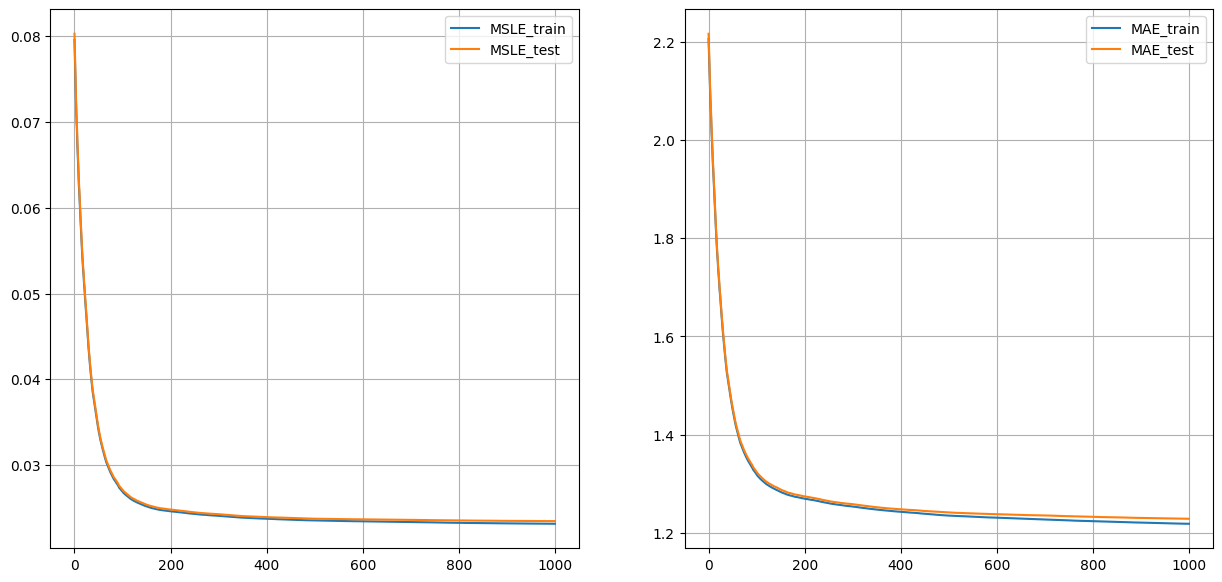

In [165]:
results = reg.get_evals_result()
mm = list(results['learn'].keys())
x = np.arange(0, n_tree)
fig, ax  = plt.subplots(1, 2, figsize=(15, 7))
print(ax[0])
for i, m in enumerate(mm):
    ax[i].plot(x, results['learn'][m], label=f'{m}_train')
    ax[i].plot(x, results['validation'][m], label=f'{m}_test')
    ax[i].grid()
    ax[i].legend()
plt.show()

### Grid search

In [138]:
grid = {'iterations': np.arange(200, 1001, 100),
        'depth': np.arange(2, 8)}
model = CatBoostRegressor(verbose=False, random_seed=13, loss_function='MAE', eval_metric='MSLE', cat_features=cat_features)
gs_res = model.grid_search(grid, X = X_train, y = y_train, cv=3, train_size=0.8)


bestTest = 0.02655717954
bestIteration = 199

0:	loss: 0.0265572	best: 0.0265572 (0)	total: 4.18s	remaining: 3m 41s

bestTest = 0.02535422342
bestIteration = 299

1:	loss: 0.0253542	best: 0.0253542 (1)	total: 10.4s	remaining: 4m 31s

bestTest = 0.02484420829
bestIteration = 399

2:	loss: 0.0248442	best: 0.0248442 (2)	total: 18.7s	remaining: 5m 17s

bestTest = 0.02454259968
bestIteration = 499

3:	loss: 0.0245426	best: 0.0245426 (3)	total: 28.9s	remaining: 6m

bestTest = 0.02435578626
bestIteration = 599

4:	loss: 0.0243558	best: 0.0243558 (4)	total: 41.5s	remaining: 6m 46s

bestTest = 0.02424395281
bestIteration = 698

5:	loss: 0.0242440	best: 0.0242440 (5)	total: 56.8s	remaining: 7m 34s

bestTest = 0.02413710292
bestIteration = 799

6:	loss: 0.0241371	best: 0.0241371 (6)	total: 1m 13s	remaining: 8m 11s

bestTest = 0.02406476485
bestIteration = 899

7:	loss: 0.0240648	best: 0.0240648 (7)	total: 1m 31s	remaining: 8m 47s

bestTest = 0.0240080983
bestIteration = 999

8:	loss: 0.0240081	b

In [150]:
print('best param:', gs_res['params'])

best param: {'depth': 7, 'iterations': 1000}


In [166]:
reg.save_model("model.cbm")

In [205]:
el = X_test.iloc[[19,20]]
print(el.to_dict('records'))
reg.predict(el)

[{'Sex': 'I', 'Length': 0.4300000071525574, 'Diameter': 0.3449999988079071, 'Height': 0.10499999672174454, 'Whole weight': 0.44699999690055847, 'Whole weight.1': 0.19599999487400055, 'Whole weight.2': 0.08250000327825546, 'Shell weight': 0.11999999731779099, 'Meat_per': 0.4384787380695343, 'Square': 0.14835000038146973, 'Mass_div_sq': 1.3211997747421265, 'Volume': 0.015576749108731747, 'Shell_density': 7.703789710998535, 'e': 0.5968866348266602}, {'Sex': 'F', 'Length': 0.574999988079071, 'Diameter': 0.42500001192092896, 'Height': 0.12999999523162842, 'Whole weight': 0.9204999804496765, 'Whole weight.1': 0.4034999907016754, 'Whole weight.2': 0.16899999976158142, 'Shell weight': 0.25, 'Meat_per': 0.4383487105369568, 'Square': 0.24437500536441803, 'Mass_div_sq': 1.6511508226394653, 'Volume': 0.03176875039935112, 'Shell_density': 7.869368553161621, 'e': 0.6735622882843018}]


array([7.78581437, 9.63371893])